## Dataset Penguin

#### 1. Carga de datos y librerías

Se prepara el entorno para importar los módulos del motor desde src/ y se cargan los datos desde ../data/penguins.csv.
Para centrar la tarea en variables morfométricas, se eliminan las columnas categóricas island y sex, y se descartan filas con valores perdidos (dropna).
Las características empleadas son:

bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g.

La etiqueta es species. Se extrae como texto, se ordena el conjunto de clases distintas (unique_classes) y se mapea cada especie a un índice entero consistente con ese orden.
Finalmente, se construye la codificación one-hot Y con tantas columnas como especies (3).
Se imprime el vector unique_classes para conocer el orden exacto que seguirá la codificación y, por tanto, el sentido de las columnas de la matriz de confusión.

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.NeuralNetwork import NeuralNetwork
from src.OptimizerAdam import OptimizerAdam
from src.Trainer import Trainer
from src.Losses import categorical_cross_entropy
from src.HyperparameterTuner import HyperparameterTuner

df = pd.read_csv("../data/penguins.csv")
df = df.drop(columns=["island", "sex"])
df = df.dropna()

X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
y_labels = df["species"].values
unique_classes = np.unique(y_labels)
y = np.array([np.where(unique_classes == label)[0][0] for label in y_labels])
Y = np.zeros((y.size, len(unique_classes)))
Y[np.arange(y.size), y] = 1
print(unique_classes)

#### 2. División en Train/Test/Val

Se fija una semilla (np.random.seed(42)) para garantizar reproducibilidad, y se realiza una permutación aleatoria de los índices del conjunto completo. Con esa permutación se crea una partición 80/10/10 en:
- entrenamiento (train_idx),
- validación (val_idx),
- prueba (test_idx).

A continuación se generan las matrices X_train, X_val, X_test y sus correspondientes etiquetas Y_train, Y_val, Y_test.
Se imprime un resumen con número de muestras, número de atributos (4) y número de clases (3).

Nota: en este cuaderno no se estandarizan explícitamente las características; el entrenamiento procede con las magnitudes originales medidas en milímetros y gramos.

In [16]:
np.random.seed(42)
indices = np.random.permutation(X.shape[0])

train_size = int(0.8 * X.shape[0])
val_size = int(0.1 * X.shape[0])

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]
print(f"Datos cargados: {X.shape[0]} muestras, {X.shape[1]} atributos, {Y.shape[1]} clases")

Datos cargados: 342 muestras, 4 atributos, 3 clases


#### 3. Búsqueda de hiperparámetros

Se define una rejilla de búsqueda que combina:
- tasas de aprendizaje [0.001,0.005,0.01,0.1],
- tamaños de lote [16,32],
- regularización L2 [1e−4,1e−3],
- arquitecturas ocultas [[18],[12],[16]],
- funciones de activación {relu,tanh},
- parámetros de Adam (𝛽1,𝛽2) ∈ {(0.9,0.999),(0.99,0.95)},
- tasas de dropout [0.0,0.2,0.5],
- número de épocas en {100,150,200}, con paciencia=10 y decaimiento=0.95.

El buscador entrena cada configuración, registra pérdida y precisión en validación y devuelve las mejores combinaciones ordenadas por best_val_acc (y, a empate, por best_val_loss). Se crea un DataFrame con todos los resultados y se visualiza la configuración superior.

In [27]:
tuner = HyperparameterTuner(X_train, Y_train, X_val, Y_val)
for e in [100, 150, 200]:
    results = tuner.search(
        lr_list=[0.001, 0.005, 0.01, 0.1],
        batch_sizes=[16, 32],
        regs=[0.0001, 0.001],
        hidden_layers=[[18], [12], [16]],
        activations=["relu", "tanh"],
        betas=[(0.9, 0.999), (0.99, 0.95)],
        dropout_rates=[0.0, 0.2, 0.5],
        epochs=e,
        patience=10,
        decay=0.95,
        seed=42
    )
df_results = pd.DataFrame(results)
best = df_results.sort_values(by=["best_val_acc", "best_val_loss"], ascending=[False, True]).head(5)
best.iloc[[0]]


 [1/192] lr=0.001, batch=16, λ=0.0001, layers=[18], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Early stopping: sin mejora tras 10 épocas.

 [2/192] lr=0.001, batch=16, λ=0.0001, layers=[18], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Early stopping: sin mejora tras 10 épocas.

 [3/192] lr=0.001, batch=16, λ=0.0001, layers=[18], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Early stopping: sin mejora tras 10 épocas.

 [4/192] lr=0.001, batch=16, λ=0.0001, layers=[18], act=relu, β=(0.99,0.95)
Decaimiento del learning rate: nuevo lr = 0.000950
Decaimiento del learning rate: nuevo lr = 0.000902
Early stopping: sin mejora tras 10 épocas.

 [5/192] lr=0.001, batch=16, λ=0.0001, layers=[18], act=relu, β=(0.99,0.95)
Decaimiento del learning rate: nuevo lr = 0.000950
Decaimiento del learning rate: nuevo lr = 0.000902
Early stopping: sin mejora tras 10 épocas.

 [6/192] lr=0.001, batch=16, λ=0.0001, lay

,id,lr,batch_size,lambda_reg,hidden_layers,activation,beta1,beta2,dropout_rate,best_val_acc,best_val_loss
0,118,0.001,32,0.001,[18],tanh,0.99,0.95,0.0,1.0,0.137389


#### 4. Modelo, optimizador y entrenamiento

Se instancia una red MLP con arquitectura [4, 18, 3]: 4 entradas (medidas morfométricas), 18 neuronas ocultas con activación tanh, 3 salidas con softmax para clasificación multiclase.

La inicialización es Xavier, la pérdida es entropía cruzada categórica y se aplica L2 con λ=10^-3
El optimizador es Adam con lr=0.001, beta1=0.99, beta2=0.95; el Trainer emplea paciencia=10 y decaimiento de la tasa de aprendizaje=0.95.
Se entrena durante 200 épocas con mini-lotes de 32 muestras, almacenando el historial de pérdida/precisión para entrenamiento y validación.

In [29]:
model = NeuralNetwork( layers=[X.shape[1], 18, Y.shape[1]], activation='tanh', output_activation='softmax', loss='cce', seed=42, init='xavier', lambda_reg=0.001, dropout_rate=0.0)
optimizer = OptimizerAdam(lr=0.001, beta1=0.99, beta2=0.95)
trainer = Trainer(model, optimizer, categorical_cross_entropy, patience=10, decay=0.95)
hist = trainer.train( X_train, Y_train, X_val, Y_val, epochs=200, batch_size=32 )

Época 001 | Train Loss: 1.1159 | Train Acc: 37.87% | Val Loss: 1.1414 | Val Acc: 35.29%
Época 002 | Train Loss: 1.1084 | Train Acc: 45.24% | Val Loss: 1.1195 | Val Acc: 35.29%
Época 003 | Train Loss: 1.0770 | Train Acc: 45.55% | Val Loss: 1.0777 | Val Acc: 35.29%
Época 004 | Train Loss: 0.9919 | Train Acc: 64.32% | Val Loss: 0.9210 | Val Acc: 82.35%
Época 005 | Train Loss: 0.9443 | Train Acc: 75.43% | Val Loss: 0.9004 | Val Acc: 79.41%
Época 006 | Train Loss: 0.9312 | Train Acc: 77.33% | Val Loss: 0.9212 | Val Acc: 79.41%
Época 007 | Train Loss: 0.9275 | Train Acc: 73.04% | Val Loss: 0.9205 | Val Acc: 79.41%
Época 008 | Train Loss: 0.9061 | Train Acc: 78.29% | Val Loss: 0.9302 | Val Acc: 79.41%
Época 009 | Train Loss: 0.8832 | Train Acc: 72.69% | Val Loss: 0.9559 | Val Acc: 38.24%
Época 010 | Train Loss: 0.9026 | Train Acc: 64.44% | Val Loss: 0.9100 | Val Acc: 79.41%
Época 011 | Train Loss: 0.8880 | Train Acc: 78.33% | Val Loss: 0.8905 | Val Acc: 76.47%
Época 012 | Train Loss: 0.8622 |

#### 5. Evaluación y visualización

Se realiza la inferencia en prueba, se calcula la precisión final y se generan las curvas de:
- evolución de la pérdida (train_loss, val_loss) por época,
- evolución de la precisión (train_acc, val_acc) por época.

Estas gráficas permiten verificar visualmente la convergencia y la posible brecha entre entrenamiento y validación.

In [41]:
Y_pred_test, _ = model.forward(X_test)
preds = np.argmax(Y_pred_test, axis=0)
true = np.argmax(Y_test, axis=1)
accuracy_test = np.mean(preds == true)
print(f"Precisión final en test: {accuracy_test*100:.2f}%")


Precisión final en test: 97.14%


5.1 Gráfica evolución de las pérdidas

Se representan las series hist["train_loss"] y hist["val_loss"] frente al número de épocas. La separación entre ambas curvas cuantifica el grado de ajuste/regularización; una validación estable y próxima a entrenamiento suele indicar buena generalización.

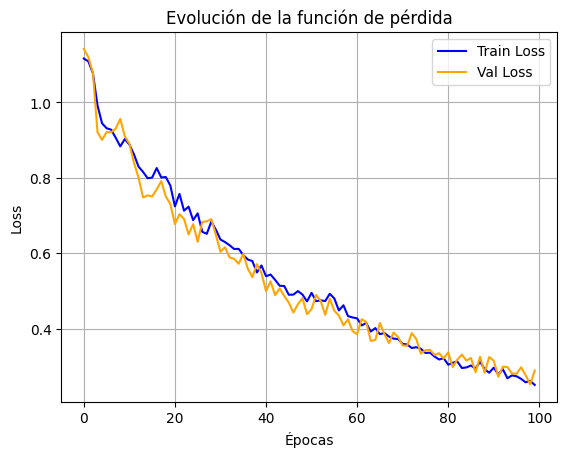

In [42]:
plt.plot(hist["train_loss"], label="Train Loss", color='blue')
plt.plot(hist["val_loss"], label="Val Loss", color='orange')
plt.title("Evolución de la función de pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


5.2 Gráfica evolución de la exactitud

Se representan hist["train_acc"] y hist["val_acc"]. Una precisión de validación que sube y se estabiliza sin divergencias notables respecto a entrenamiento sugiere ausencia de sobreajuste.

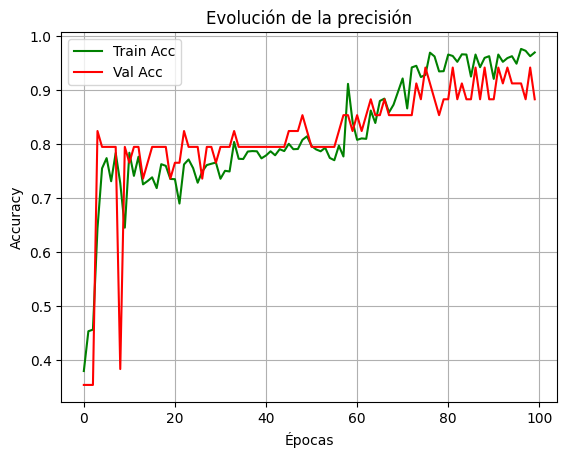

In [43]:
plt.plot(hist["train_acc"], label="Train Acc", color='green')
plt.plot(hist["val_acc"], label="Val Acc", color='red')
plt.title("Evolución de la precisión")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

5.3 Matriz de confusión

Se construye una matriz de confusión a partir de las predicciones en prueba.
La matriz está indexada según el orden de unique_classes mostrado al inicio, por lo que:
- la diagonal recoge aciertos por especie,
- los términos fuera de la diagonal indican confusiones entre clases.

Su inspección ayuda a identificar solapamientos biométricos entre especies y posibles necesidades de normalización o ajuste de arquitectura si se observan patrones de error sistemáticos.

In [44]:
def confusion_matrix_simple(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    n = len(labels)
    matrix = np.zeros((n, n), dtype=int)
    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    print("Matriz de confusión:")
    print("   Predicciones →")
    print("Reales ↓")
    for i, true_label in enumerate(labels):
        print(f"{true_label:>8} |", " ".join(f"{x:4d}" for x in matrix[i]))
    return matrix

confusion_matrix_simple(y_true, y_pred)


Matriz de confusión:
   Predicciones →
Reales ↓
       0 |   14    0    0
       1 |    1    6    0
       2 |    0    0   14


array([[14,  0,  0],
       [ 1,  6,  0],
       [ 0,  0, 14]])